In [6]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Day 25 Lecture 1 Assignment

In this assignment, we will evaluate the performance of the model we built yesterday on the Chicago traffic crash data. We will also perform hyperparameter tuning and evaluate a final model using additional metrics (e.g. AUC-ROC, precision, recall, etc.)

In [7]:
import numpy as np
import pandas as pd

# progress bar
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    log_loss,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    make_scorer,
)
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Since we will be building on the model we built in the last assignment, we will need to redo all of the data preparation steps up to the point of model building. These steps include creating the response, missing value imputation, and one-hot encoding our selected categorical variables. The quickest way to get going would be to open last week's assignment, make a copy, and build on it from there.

In [8]:
# Copy pasted work from `Copy_of_Day_24_Lecture_2_Assignment.ipynb`
crash_data = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv"
)

# Binarize damage, we will predict if over 1500 or not
crash_data["is_over_1500"] = crash_data["DAMAGE"] == "OVER $1,500"
crash_data["is_over_1500"] = crash_data["is_over_1500"].astype(int)
crash_data = crash_data.drop(columns=["DAMAGE"])


# Dropping all columns with more than 5% missing data
is_na_perc = crash_data.isna().mean()
drop_cols = is_na_perc[is_na_perc > 0.05].index
crash_data = crash_data.drop(columns=drop_cols)

# Imputing the median for numeric columns with less than 5% missing data (except for STREET_NO)
col_medians = crash_data.drop(columns="STREET_NO").median()
crash_data = crash_data.fillna(col_medians)

# Dropping rows with missing data for categorical columns that have less than 5% missing data
crash_data = crash_data.dropna()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
x_cols = [
    "POSTED_SPEED_LIMIT",
    "WEATHER_CONDITION",
    "INJURIES_TOTAL",
    "FIRST_CRASH_TYPE",
]
X = crash_data[x_cols]
y = crash_data["is_over_1500"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# This is a sneaky way that the model is 'learning' from the testing data!
# pd.get_dummies is convenient, but it's not best practice
# We should split the data before transforming in any way

# drop_cats = ["WEATHER_CONDITION_CLEAR", "FIRST_CRASH_TYPE_REAR END"]
# X_dummies = pd.get_dummies(X)
# X_dummies = X_dummies.drop(columns=drop_cats)

<IPython.core.display.Javascript object>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# This is a hacky way to use OneHotEncoder compared to its intended usage
# We'll eventually look at `sklearn.compose.ColumnTransformer` for a better
# streamlined way to do this.

# What columns to encode
cat_cols = ["WEATHER_CONDITION", "FIRST_CRASH_TYPE"]
drop_cats = ["CLEAR", "REAR END"]

encoder = OneHotEncoder(drop=drop_cats, sparse=False)
encoder.fit(X_train[cat_cols])

train_dummies = encoder.transform(X_train[cat_cols])
test_dummies = encoder.transform(X_test[cat_cols])


col_names = encoder.get_feature_names(cat_cols)
train_dummies = pd.DataFrame(train_dummies, index=X_train.index, columns=col_names)
test_dummies = pd.DataFrame(test_dummies, index=X_test.index, columns=col_names)

train_dummies.head(2)

,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,WEATHER_CONDITION_UNKNOWN,...,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING
145640,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
X_train = X_train.drop(columns=cat_cols)
X_test = X_test.drop(columns=cat_cols)

X_train = pd.concat((X_train, train_dummies), axis="columns")
X_test = pd.concat((X_test, test_dummies), axis="columns")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Statsmodels' implementation of logistic has certain advantages over scikit-learn's, such as clean, easy to read model summary output and statistical inference values (e.g. p-values). However, scikit-learn is preferable for model evaluation, so we will switch to the scikit-learn implementation for this exercise. 

Run logistic regression on the training set and use the resulting model to make predictions on the test set. Calculate the train and test error using logarithmic loss. How do they compare to each other?

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
model.score(X_train, y_train)

0.583093666590801

<IPython.core.display.Javascript object>

In [13]:
model.score(X_test, y_test)

0.5858725188628495

<IPython.core.display.Javascript object>

Next, evaluate the performance of the same model using 10-fold CV. Use the training data and labels, and print out the mean log loss for each of the 10 CV folds, as well as the overall CV-estimated test error. How do the estimates from the individual folds compare to the result from our previous single holdout set? How much variability in the estimated test error do you see across the 10 folds?

Note: scikit-learn's *cross_val_score* function provides a simple, one-line method for doing this. However, be careful - the default score returned by this function may not be log loss!

In [14]:
# CV of 10 is kinda slow to fit...

# This uses model.score (accuracy)
cross_val_score(model, X_train, y_train, cv=3)

array([0.58209017, 0.58196603, 0.58652832])

<IPython.core.display.Javascript object>

In [17]:
# We can use a different scoring metric.

# If we do this line of code we get an error:
# cross_val_score(model, X_train, y_train, cv=3, scoring=log_loss)

# ValueError: scoring value <function log_loss at 0x129452d40> looks
# like it is a metric function rather than a scorer. A scorer should
# require an estimator as its first parameter. Please use `make_scorer`
# to convert a metric to a scorer.

<IPython.core.display.Javascript object>

In [20]:
log_loss_scorer = make_scorer(log_loss, needs_proba=True)
cross_val_score(model, X_train, y_train, cv=3, scoring=log_loss_scorer)

array([0.65822625, 0.65861933, 0.65816977])

<IPython.core.display.Javascript object>

Scikit-learn's logistic regression function has a built-in regularization parameter, C (the larger the value of C, the smaller the degree of regularization). Use a loop with values of C, and find the optimum C value by taking the highest average cross validation score.

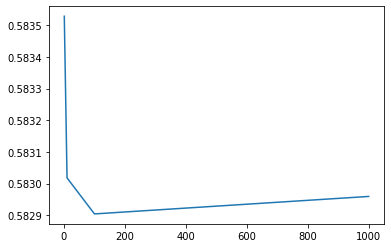

<IPython.core.display.Javascript object>

In [27]:
cs = [1, 10, 100, 1000]

avg_cv_scores = []
for c in tqdm(cs):
    model = LogisticRegression(C=c, max_iter=1000)

    # pick your poison
    cv_scores = cross_val_score(model, X_train, y_train, cv=3)
    #     cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=log_loss_scorer)

    avg_cv_score = cv_scores.mean()
    avg_cv_scores.append(avg_cv_score)

plt.plot(cs, avg_cv_scores)
plt.show()

Re-train a logistic regression model using the best value of C identified by 10-fold CV on the training data and labels. Afterwards, do the following:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Note: the performance of our simple logistic regression model with just four features will not be very good, but this is not entirely unexpected. There are many other features that can be incorporated into the model to improve its performance; feel free to experiment!

In [28]:
model = LogisticRegression(C=1, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [38]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
y_prob_1 = y_prob[:, 1]

<IPython.core.display.Javascript object>

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.30      0.39     31836
           1       0.60      0.81      0.69     40661

    accuracy                           0.59     72497
   macro avg       0.57      0.56      0.54     72497
weighted avg       0.58      0.59      0.56     72497



<IPython.core.display.Javascript object>

In [40]:
confusion_matrix(y_test, y_pred)

array([[ 9623, 22213],
       [ 7810, 32851]])

<IPython.core.display.Javascript object>

In [42]:
roc_auc_score(y_test, y_prob_1)

0.6199621717724726

<IPython.core.display.Javascript object>

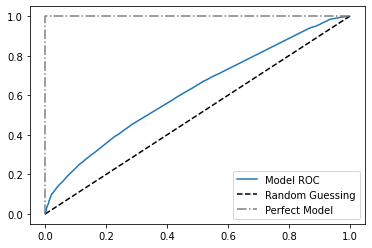

<IPython.core.display.Javascript object>

In [54]:
fpr, tpr, thresh = roc_curve(y_test, y_prob_1)

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "-.", c="gray", label="Perfect Model")
plt.legend()
plt.show()